In [69]:
from datetime import datetime

# Get the current date and time
current_datetime = datetime.now()

print(current_datetime)

2024-10-24 22:52:49.681240


# Spatio Temporal Logistic
This notebook is the first test of a spatio temporal logistic to link properly the **built-up surface** of a given region depending on its quality of life (**GDP/cap**) and of its **population density**.

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from Region import Region
import pandas as pd
import os

## Part 0 : Theory
First we define some classical functions that will be used later for our modelisation.

### The logistic function
$f(t) = \frac{S}{1+e^{(-k(t-t_0))}}$

with: 
- *S* : the saturation level
- *k* : the slope
- $t_0$ : the half height value (left right alignement).

The logistic function serves as a predictive equation and as the motor of our dynamical models. Indeed, we observe that at the country scale, as time passes, the GDP/cap increases and some observables as the number of cars or as the number of m2/cap. This means that the quality of life, and thus the stocks consumed by a region improve. But this exponential growth does not increase indefinetely. A saturation is observed even if the GDP/cap still increase. This is explained because people usually do not own 2 or 3 cars even though they possess the money to. An logistic function, also known as the S curve, is a way to model this observation.

### The exponential decay function
$f(x) = a\, e^{-b\,x}+c$

with:
- *a* : the slope
- *b* : the half-life ?
- *c* : the bias.

The exponential decay is a decreasing exponential observed in nature (for example for the probability of nuclear decay over time). This is one of our assumption to model the decreasing phenomena observed betwenn the **built-up surface/cap** and the **population density** of a region.

In [71]:
def logistic(x, a, b, c):
    return a / (1 + np.exp(-b*(x-c)))

def exponential_decay(X, a, b, c):
    return a * np.exp(-b * X) + c

def exponential_decay2(X, a, b):
    return a * np.exp(-b * X) 

### The Spatio Temporal Logistic function
$f(t,x) = \frac{a\,e^{-b\,x}+c}{1 + e^{(-k(t-t_0))}}$

The Spatio Temporal Logistic function (**STL**) is the mix between our classical logistic expression and the exponential decay as S (the saturation level).

In [72]:
def STL(X, a, b, c, d, e):
    # STL stands for Spatio Temporal Logistic. It is an refinment of a logistic, dependant on time (here the GDP per capita serves 
    # as proxy for time), with a saturation level which is a function of space (here the population density of a region)
    x1, x2 = X
    saturation = exponential_decay(x2, a, b,c)
    return saturation / (1 + np.exp(-d*(x1-e)))

## PART 1 : Initialisation
Initialisation of the analysis parameters.

- **region_names** : (*string*) the country to study, named by their ISO3 
- **years** : (*string*) years to study
- **raster_S** : (*string*) letter used in the **GHSL** dataset (S, S_NRES, POP, ...)
- **lvl** : (*int*) the level of our administrative data (GDP and population)
- **subregion_borders** : (*string*) the path to administrative border shapefile to cut the subregions 
- **i dentifier** : (*string*) the column name to match the region names between the administrative data and the GIS data

To each region is associated a **DataFrame** (*oecd_DF_merged*) with the subregions matching administrative observables (GDP, population, etc).

In [73]:
lvl = 2

In [74]:
# Make the OECD complete DF
oecd_gdp_per_cap_file = r"/data/mineralogie/hautervo/data/OECD/GDP per capita/TL" + str(lvl) + r"/Gross Domestic Product per capita, in USD.csv"
oecd_population_file = r"/data/mineralogie/hautervo/data/OECD/Population/TL" + str(lvl) + r"/Resident population.csv"

oecd_gdp_per_capita_df = pd.read_csv(oecd_gdp_per_cap_file, skiprows=0, header=1)
oecd_population_df = pd.read_csv(oecd_population_file, skiprows=0, header=1)

df_list = []
df_list.append(oecd_gdp_per_capita_df)
df_list.append(oecd_population_df)

subregion_col = "tl"+str(lvl)+"_id"
parent_col = "iso3"

for df in df_list:
    df[subregion_col] = df["Code"]

In [75]:
# The OECD admin units

oecd_admin_units = "/data/mineralogie/hautervo/data/OECD/admin_units/TL" + str(lvl) + "/OECD_TL" + str(lvl) + "_2020.shp"

In [76]:
# Countries to ignore from our study (too big)
country_to_pop = ["AUS", "USA"]
country_to_pop = []

In [77]:
regions_names = list(oecd_gdp_per_capita_df["Country"].unique())

#exclude the countries
for c in country_to_pop:
    regions_names.pop(regions_names.index(c))

# regions_names = ["FRA", "DEU", "GBR", "BEL", "ITA", "LUX", "ESP", "USA", "JPN", "CAN", "AUS"] # to remove
regions_names = ["FRA", "DEU"] # to remove
#regions_names = ["BEL"]
# regions_names = ["AUS"]

print(regions_names, "\n")

# years = ["1975", "1990", "2000", "2010", "2020"] # FRA
# years = ["1990", "2010", "2020"] # DEU
years = ["2000", "2010", "2020"]
#years = ["2020"]

raster_str = "S"

regions = []

for name in regions_names:
    new_region = Region(name, lvl-1)
    regions.append(new_region)

    for y in years:        
        new_region.add_gis("/data/mineralogie/hautervo/data/GHSL/Built_"+ raster_str + "/E" + y + "_100m_Global/subregions/" + name + ".tif", name + "_" + y, str(y), lvl-1) 



['FRA', 'DEU'] 

Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2000_100m_Global/subregions/FRA.tif  added to region  FRA
Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2010_100m_Global/subregions/FRA.tif  added to region  FRA
Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2020_100m_Global/subregions/FRA.tif  added to region  FRA
Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2000_100m_Global/subregions/DEU.tif  added to region  DEU
Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2010_100m_Global/subregions/DEU.tif  added to region  DEU
Raster  /data/mineralogie/hautervo/data/GHSL/Built_S/E2020_100m_Global/subregions/DEU.tif  added to region  DEU


In [78]:
output_df_path = "/data/mineralogie/hautervo/data/Outputs/GHSL/Built_" + raster_str + "/OECD/TL" + str(lvl) + "/"

## PART 2 : Computation of the observables
Now that we define all the parameters of our study, we will cut the regions into their respective subregions (*make_subregions*). 

We then compute for each subregions GIS, the geographical observables that we store in its oecd_DF_merged.

In [79]:
#### Get the computed observables
force_recompute = False
for region in regions:
    region.make_subregions(oecd_admin_units, subregion_col, parent_col)
    for subregion in region.subregions:
        csv_path = os.path.join(output_df_path, region.name, subregion.name, '_'.join(years))+".csv"
        if not os.path.isfile(csv_path) or force_recompute:
            subregion.output_df = pd.DataFrame(data=years, columns=["year"])

            for y in years:
                gis = subregion.gis_list[years.index(y)]
    
                subregion.output_df.loc[subregion.output_df["year"]==y, "Built up surface GHSL"] = int(gis.get_total_sum_pixel_values())
                subregion.output_df.loc[subregion.output_df["year"]==y, "Total surface"] = int(1e4 * gis.get_total_number_pixels() )
                subregion.output_df.loc[subregion.output_df["year"]==y, "Built up surface fraction"] = float(subregion.output_df.loc[subregion.output_df["year"]==y, "Built up surface GHSL"] / subregion.output_df.loc[subregion.output_df["year"]==y, "Total surface"])

                try:
                    subregion.output_df.loc[subregion.output_df["year"]==y, "GDP per capita"] = float(oecd_gdp_per_capita_df.loc[oecd_gdp_per_capita_df[subregion_col]==subregion.name, y].values[0])
                except:
                    print("Missing: ", subregion.name, " ", y, " GDP per capita.")
                
                try:
                    subregion.output_df.loc[subregion.output_df["year"]==y, "Population"] = float(oecd_population_df.loc[oecd_population_df[subregion_col]==subregion.name, y].values[0]  )                  
                    subregion.output_df.loc[subregion.output_df["year"]==y, "Population/Total surface"] = float(subregion.output_df.loc[subregion.output_df["year"]==y, "Population"] / subregion.output_df.loc[subregion.output_df["year"]==y, "Total surface"])
                    # output
                    subregion.output_df.loc[subregion.output_df["year"]==y, "Built up surface GHSL/Population"] = float(subregion.output_df.loc[subregion.output_df["year"]==y, "Built up surface GHSL"] / subregion.output_df.loc[subregion.output_df["year"]==y, "Population"])
                except:
                    print("Missing: ", subregion.name, " ", y, " Population.")

            # save the new df
            os.makedirs(os.path.dirname(csv_path), exist_ok="True")
            subregion.output_df.to_csv(csv_path, index=False)
        else:
            #use a precomputed csv
            subregion.output_df = pd.read_csv(csv_path)

Warning the CRS do not match! The code below is not working for now
Something went wrong while trying to cut a raster for
 FRY1 Input shapes do not overlap raster.
Warning the CRS do not match! The code below is not working for now
Something went wrong while trying to cut a raster for
 FRY1 Input shapes do not overlap raster.
Warning the CRS do not match! The code below is not working for now
Something went wrong while trying to cut a raster for
 FRY1 Input shapes do not overlap raster.
Warning the CRS do not match! The code below is not working for now
Something went wrong while trying to cut a raster for
 FRY2 Input shapes do not overlap raster.
Warning the CRS do not match! The code below is not working for now
Something went wrong while trying to cut a raster for
 FRY2 Input shapes do not overlap raster.
Warning the CRS do not match! The code below is not working for now
Something went wrong while trying to cut a raster for
 FRY2 Input shapes do not overlap raster.
Warning the CRS 

## PART 3 : First analysis and plots
Here we can, if we want or need to, filter some subregions from our study. 

Thus, we can plot our observables.

In [80]:
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('xx-small')

colors_reg = [
    "black", "red", "peru", "darkorange", "gold", "purple", "magenta", 
    "yellow", "chartreuse", "turquoise", "darkcyan", "deepskyblue", 
    "blue", "orange", "green", "brown",
    # Additional colors
    "crimson", "lime", "orchid", "coral", "navy", "teal", "darkred", 
    "salmon", "plum", "seagreen", "midnightblue", "lightseagreen", 
    "dodgerblue", "sienna", "hotpink", "darkviolet", "lightcoral", 
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
    "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#a6cee3", "#1f78b4", 
    "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", "#fdbf6f", "#ff7f00", 
    "#cab2d6", "#6a3d9a", "#ffff99", "#b15928", "#6b6ecf", "#9c9ede", 
    "#31a354", "#74c476", "#a1d99b", "#d9d9d9", "#636363", "#969696"
]

### PLOT 1.1 : Total observable compared to time

In [81]:
if False:
    x_col = "year"
    y_col = "Built up surface GHSL"

    for region in regions:
        k = 0
        try:
            for subregion in region.subregions:
                filtered_df = subregion.output_df.dropna(subset=[x_col, y_col])
                x = filtered_df[x_col]
                y = filtered_df[y_col]
        
                plt.scatter(x, y, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)
        
                k = k + 1
        
            plt.title(region.name + "'s regions in " + str(years))
            plt.ylabel("Observed built-up surface (m²)")
            plt.xlabel("year")
            plt.legend(loc="upper right", prop=fontP)
            plt.show()
        except Exception as e:
            print(region.name, "\n", e)

### PLOT 1.2 : Observable per capita compared to time

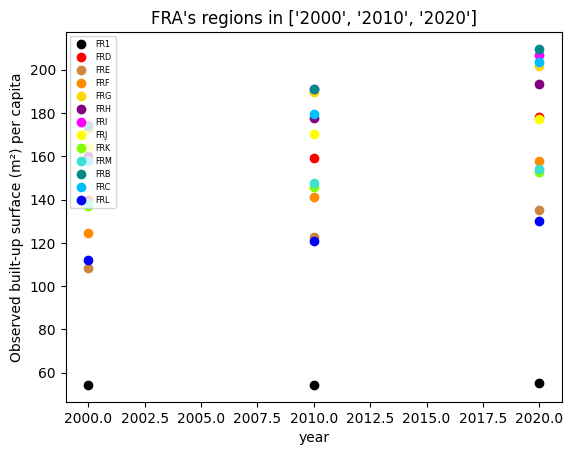

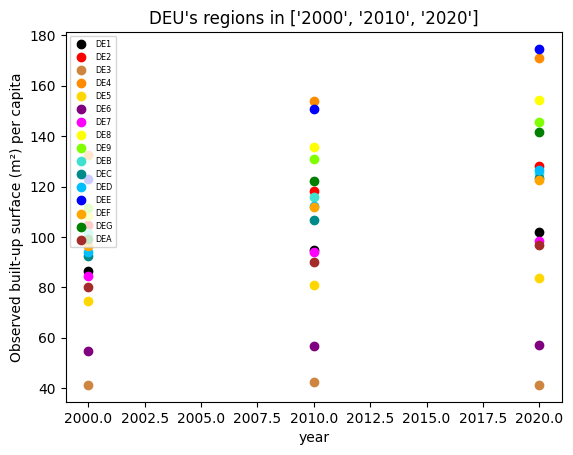

In [82]:
if True:
    x_col = "year"
    y_col = "Built up surface GHSL/Population"

    for region in regions:
        k = 0
        try:
            for subregion in region.subregions:
                filtered_df = subregion.output_df.dropna(subset=[x_col, y_col])
                x = filtered_df[x_col]
                y = filtered_df[y_col]
        
                plt.scatter(x, y, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)
        
                k = k + 1
        
            plt.title(region.name + "'s regions in " + str(years))
            plt.ylabel("Observed built-up surface (m²) per capita")
            plt.xlabel("year")
            plt.legend(loc="upper left", prop=fontP)
            plt.show()
        except Exception as e:
            print(region.name, "\n", e)

### PLOT 2.1 : Total observable compared to GDP

In [83]:
if False:
    x_col1 = "GDP per capita"
    x_col2 = "Population"
    y_col = "Built up surface GHSL"

    for region in regions:
        k = 0
        try:
            for subregion in region.subregions:
                filtered_df = subregion.output_df.dropna(subset=[x_col1, x_col2, y_col])
                x = filtered_df[x_col1].mul(filtered_df[x_col2]) # TODO how to add year here ?
                y = filtered_df[y_col]
        
                plt.scatter(x, y, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)
        
                k = k + 1
        
            plt.title(region.name + "'s regions in " + str(years))
            plt.ylabel("Observed built-up surface (m²)")
            plt.xlabel("GDP (€)")
            plt.legend(loc="upper right", prop=fontP)
            plt.show()
        except Exception as e:
            print(region.name, "\n", e)

### PLOT 2.2 : Observable per capita compared to GDP per capita

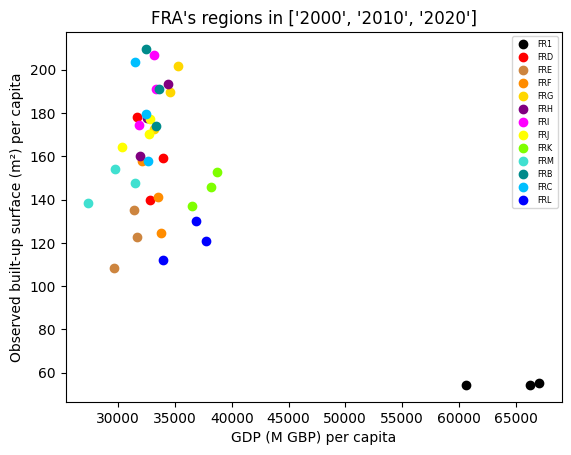

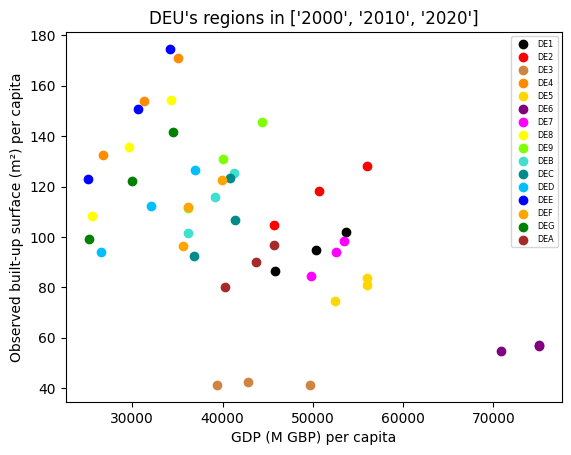

In [84]:
if True:
    x_col = "GDP per capita"
    y_col = "Built up surface GHSL/Population"

    for region in regions:
        k = 0
        try:
            for subregion in region.subregions:
                filtered_df = subregion.output_df.dropna(subset=[x_col, y_col])
                x = filtered_df[x_col]
                y = filtered_df[y_col]
        
                plt.scatter(x, y, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)
        
                k = k + 1
        
            plt.title(region.name + "'s regions in " + str(years))
            plt.ylabel("Observed built-up surface (m²) per capita")
            plt.xlabel("GDP (M GBP) per capita")
            plt.legend(loc="upper right", prop=fontP)
            plt.show()
        except Exception as e:
            print(region.name, "\n", e)

### PLOT 3.1 : Observable per capita compared to observable fraction (m2 built up / all m2)

In [85]:
if False:    
    x_col = "Built up surface fraction"
    y_col = "Built up surface GHSL/Population"

    for region in regions:
        k = 0
        try:
            for subregion in region.subregions:
                filtered_df = subregion.output_df.dropna(subset=[x_col, y_col])
                x = filtered_df[x_col]
                y = filtered_df[y_col]
        
                plt.scatter(x, y, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)
        
                k = k + 1
        
            plt.title(region.name + "'s regions in " + str(years))
            plt.ylabel("Observed built-up surface (m²) per capita")
            plt.xlabel("Built up surface fraction")
            plt.legend(loc="upper right", prop=fontP)
            plt.show()
        except Exception as e:
            print(region.name, "\n", e)

### PLOT 3.2 : Observable per capita compared to population density

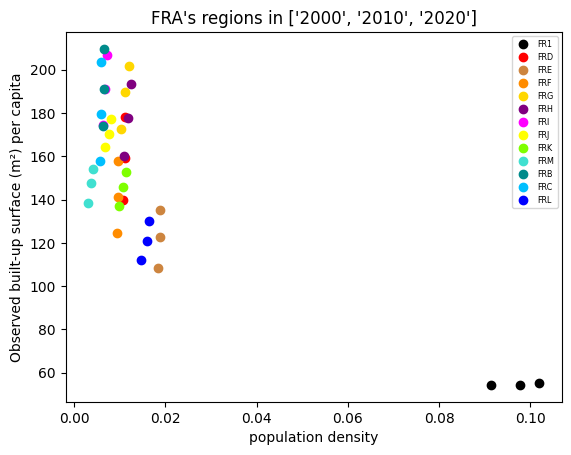

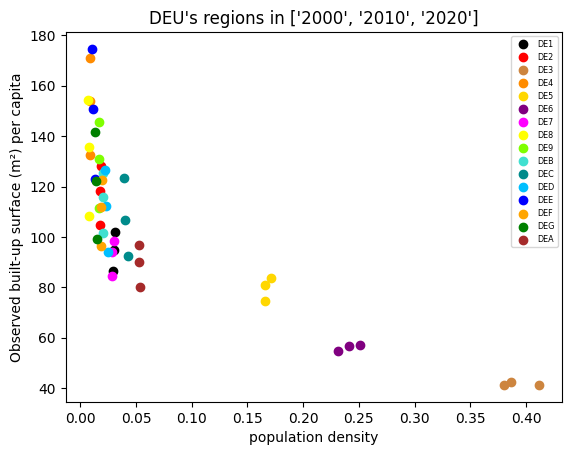

In [86]:
if True: 
    x_col = "Population/Total surface"
    y_col = "Built up surface GHSL/Population"

    for region in regions:
        k = 0
        try:
            for subregion in region.subregions:
                filtered_df = subregion.output_df.dropna(subset=[x_col, y_col])
                x = filtered_df[x_col]
                y = filtered_df[y_col]
        
                plt.scatter(x, y, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)
            
                k = k + 1
        
            plt.title(region.name + "'s regions in " + str(years))
            plt.ylabel("Observed built-up surface (m²) per capita")
            plt.xlabel("population density")
            plt.legend(loc="upper right", prop=fontP)
            plt.show()
        except Exception as e:
            print(region.name, "\n", e)

## PART 4 : Fitting

The fitting part consists of several parts. We do the fits in seperate steps for two reasons. First because the fits are better if we feed it with coherent initial parameter values. Secondly because it is best for us to get a clear picture of what are fitted functions look like.

1. We fit the classical logistic part only (observable/cap vs GDP/cap) region by region to get an idea of appropriate fit parameter values.

2. We fit the exponential decay part only (observable/cap vs population density) for one year to get an idea of appropriate fit parameter values.

3. We fit the Spatio Temporal Logistic function. In order to have better results, we start the fitting algorithm with initial parameter values close to the one found in the first two step described above.

4. 

In [87]:
from Fit import Fit

#### PART 4.1 : Fit the logistic only

In [88]:
# # Concatenate all the data points

df_gdp_cap_region_handler = []
df_pop_density_region_handler = []
df_built_up_region_handler = []

x_col1 = "GDP per capita"
x_col2 = "Population/Total surface"
y_col = "Built up surface GHSL/Population"

for region in regions:
    df_gdp_cap_region = []
    df_pop_density_region = []
    df_built_up_region = []

    for subregion in region.subregions:
        filtered_df = subregion.output_df.dropna(subset=["year", x_col1, x_col2, y_col])
        df_gdp_cap_region = df_gdp_cap_region + filtered_df[x_col1].to_list()
        df_pop_density_region = df_pop_density_region + filtered_df[x_col2].to_list()
        df_built_up_region = df_built_up_region + filtered_df[y_col].to_list()      

    if df_gdp_cap_region and df_pop_density_region and df_built_up_region:
        df_gdp_cap_region_handler.append(df_gdp_cap_region)
        df_pop_density_region_handler.append(df_pop_density_region)
        df_built_up_region_handler.append(df_built_up_region)
    else:
       df_gdp_cap_region_handler.append([0, 0])
       df_pop_density_region_handler.append([0, 0])
       df_built_up_region_handler.append([0, 0])
       print(region.name, " is  empty and won't be fitted")

In [89]:
# fit logistic over time, region by region
logistic_fit_handler = []

j = -1
for region in regions:
    j = j + 1
    print(region.name, "\n")
        
    logistic_fit_handler.append(Fit(region.name + "_logistic", np.array(df_gdp_cap_region_handler[j]), [0,0], np.array(df_built_up_region_handler[j])))
    logistic_fit_handler[-1].fit_logistic(init=[150, 0.00001, 45000])

    print(subregion.name, " ", logistic_fit_handler[-1].fitted_params)
    print(subregion.name, " R squared ", ": ", logistic_fit_handler[-1].r_squared)

FRA 

DEA   [305.8753135648411, 2.427698527404813e-17, 291.7435152022699]
DEA  R squared  :  -2.263522702605769e-12
DEU 

DEA   [212.26328741123038, 1.269882175587895e-19, 163.87809597867818]
DEA  R squared  :  -3.1086244689504383e-15


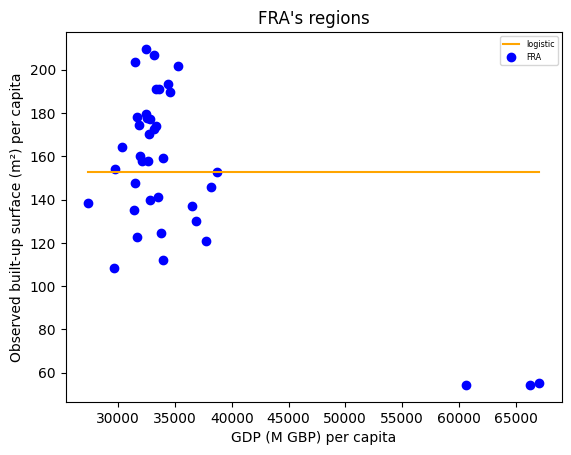

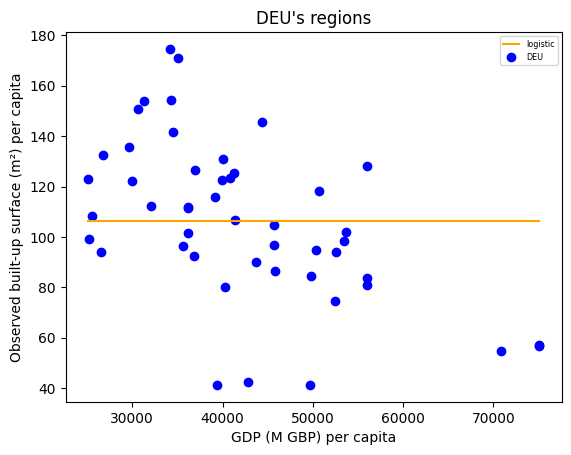

In [90]:
# # PLOT verification

j=0
for region in regions:
    x_fit_array = np.linspace(min(df_gdp_cap_region_handler[j]), max(df_gdp_cap_region_handler[j]), 10)

    plt.plot(x_fit_array, logistic(x_fit_array, logistic_fit_handler[j].fitted_params[0], logistic_fit_handler[j].fitted_params[1], logistic_fit_handler[j].fitted_params[2]), color='orange',
             label="logistic")
    plt.scatter(df_gdp_cap_region_handler[j], df_built_up_region_handler[j],  color='b', label=region.name)
    plt.title(region.name + "'s regions")
    plt.ylabel("Observed built-up surface (m²) per capita")
    plt.xlabel("GDP (M GBP) per capita")
    plt.legend(loc="upper right", prop=fontP)
    plt.show()

    j = j + 1

#### PART 4.2 : Fit the saturation only

In [91]:
# # fit the saturation fct for one year
saturation_fit_handler = []

j = 0
for region in regions:
    # fit rexponential decay
    saturation_fit_handler.append(Fit(region.name + "_exponential", np.array(df_pop_density_region_handler[j]), [0,0], np.array(df_built_up_region_handler[j])))
    saturation_fit_handler[-1].fit_exponential_decay(init=[.05, 50, 0])
    print("\n",region.name, " ", saturation_fit_handler[-1].fitted_params)
    print("R squared for : ", saturation_fit_handler[-1].r_squared)
    j = j + 1



 FRA   [154.37262956738684, 25.762484361202983, 40.794427088702356]
R squared for :  0.6453593838198806

 DEU   [104.33162371372859, 29.696781521861784, 59.802298677545345]
R squared for :  0.7438443728414006


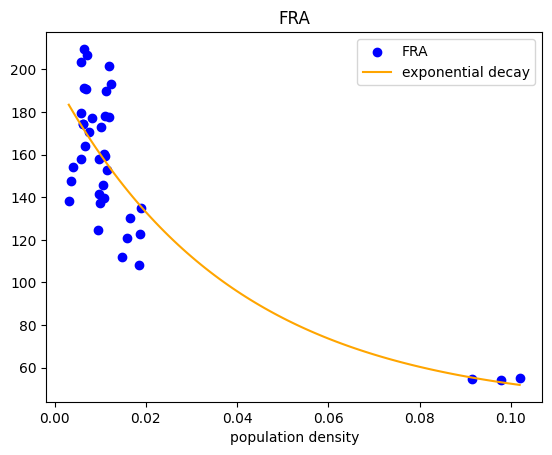

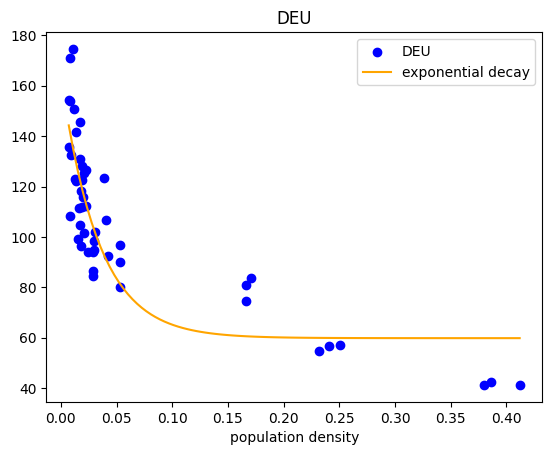

In [92]:
#  PLOT verification
j = 0
for region in regions:
    x_fit_array = np.linspace(min(df_pop_density_region_handler[j]), max(df_pop_density_region_handler[j]), 10)
    plt.scatter(df_pop_density_region_handler[j], df_built_up_region_handler[j],  color="b",
            label=region.name)
    plt.plot(saturation_fit_handler[j].x1_fit, saturation_fit_handler[j].y_fit, label="exponential decay", color="orange") 
    plt.xlabel("population density")
    plt.legend(loc="upper right")
    plt.title(region.name)
    plt.show()
    j = j + 1

Test Again with V2

In [93]:
# # fit the saturation fct for one year
saturation_fit_handler = []

j = 0
for region in regions:
    # fit rexponential decay
    saturation_fit_handler.append(Fit(region.name + "_exponential", np.array(df_pop_density_region_handler[j]), [0,0], np.array(df_built_up_region_handler[j])))
    saturation_fit_handler[-1].fit_exponential_decay2(init=[.05, 50])
    print("\n",region.name, " ", saturation_fit_handler[-1].fitted_params)
    print("R squared for : ", saturation_fit_handler[-1].r_squared)
    j = j + 1



 FRA   [185.3380854072965, 14.11207874304584]
R squared for :  0.6356884913064367

 DEU   [127.4297479829776, 3.4590723695195056]
R squared for :  0.6525904797151103


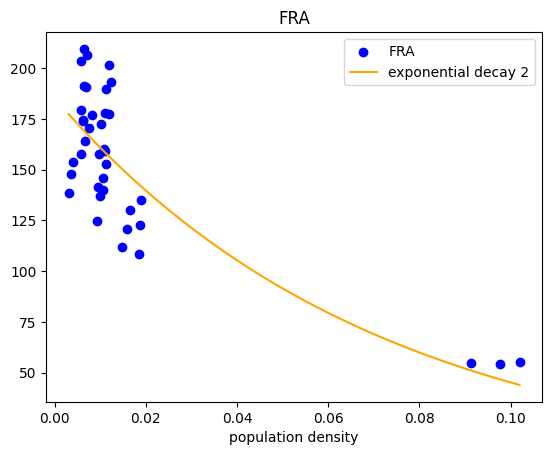

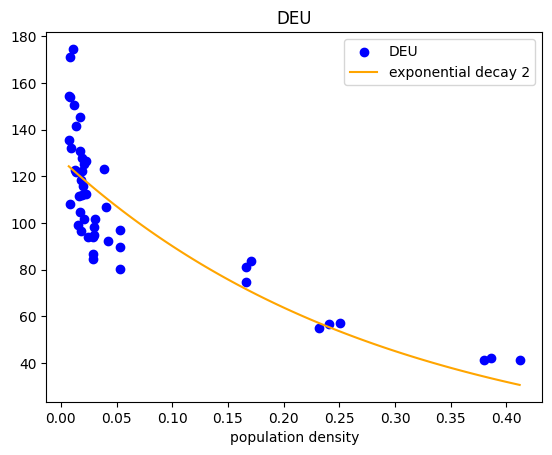

In [94]:
#  PLOT verification
j = 0
for region in regions:
    x_fit_array = np.linspace(min(df_pop_density_region_handler[j]), max(df_pop_density_region_handler[j]), 10)
    plt.scatter(df_pop_density_region_handler[j], df_built_up_region_handler[j],  color="b",
            label=region.name)
    plt.plot(saturation_fit_handler[j].x1_fit, saturation_fit_handler[j].y_fit, label="exponential decay 2", color="orange") 
    plt.xlabel("population density")
    plt.legend(loc="upper right")
    plt.title(region.name)
    plt.show()
    j = j + 1

#### PART 4.3 : Fit of the Spatio Temporal Logistic function

Now that we have an idea of the parameters and their fitness we can derive parameters for the Spatio Temporal Logistic function as a whole. For this, we concatenate all our points, all regions, all years.

In [95]:
# fit STL logistic with density
STL_fit_handler = []

for i in range(len(regions)):
    try:
        STL_fit_handler.append(Fit("tmp", np.array(df_gdp_cap_region_handler[i]), np.array(df_pop_density_region_handler[i]), np.array(df_built_up_region_handler[i])))
        STL_fit_handler[-1].fit_STL(init=[15, 30, 745, 0.00001, 30000])
    
        print(regions[i].name)
        print("Final STL fct")
        print("R squared for ", ": ", STL_fit_handler[-1].r_squared)
        print(STL_fit_handler[-1].fitted_params)
        print("")
    except Exception as e:
        print(regions[i].name, "\n", e)

        

FRA
Final STL fct
R squared for  :  0.7074584146591018
[167.91150204383635, 36.114141519068326, 48.8645000438999, 0.0005663791816540508, 26160.916493601555]

DEU
Final STL fct
R squared for  :  0.7518666740754782
[198.71763949278605, 33.398417346919345, 94.98261317116531, 1.0005298403691827e-05, 4.384052555004149e-11]



#### PART 4.4 : Store the values

At this step, we successfully fitted the function STL to all our available data. But, as we may want to use different values for the rest of our study, it is good to save the values of the study. For example, if I want to see if the values found on FRA are consistent with data from DEU, I may continue with the fitted parameters of FRA even though my current study is on DEU.

FITTED PARAMETERS:
|  Regions | years  | R²  | Values  | 
|---|---|---|---|
|  FRA | [1975, 1990, 2000, 2010, 2020]  | 0.872  | [379.7504189082203, 34.20651548329122, 53.14129351418502, 7.425803059587641e-05, 26457.87245766918]  |   
| DEU  |  [1990, 2010, 2020] | 0.816  |  [163.33898040560297, 39.972102574099054, 64.25203545135804, 7.831134965918744e-05, 5859.5488263881125] |   
|   |   |   |   |   

#### PART 5 : the STL function fit

The surface is the fitted Spatio Temporal logistic function.
The points are the data

In [96]:
import plotly.graph_objects as go

for j in range(len(regions)):
    try:
        # Create a meshgrid of x and y values
        x = np.linspace(0.5*min(df_gdp_cap_region_handler[j]), 1.5*max(df_gdp_cap_region_handler[j]), 50)
        y = np.linspace(0.5*min(df_pop_density_region_handler[j]), 1.5*max(df_pop_density_region_handler[j]), 50)
        x_grid, y_grid = np.meshgrid(x, y)
        z = STL([x_grid,y_grid], STL_fit_handler[j].fitted_params[0], STL_fit_handler[j].fitted_params[1], STL_fit_handler[j].fitted_params[2], STL_fit_handler[j].fitted_params[3], STL_fit_handler[j].fitted_params[4])
        cmin = np.min(z)
        cmax = np.max(z)
        
        # Create the surface plot using Plotly
        fig = go.Figure(data=[
            go.Surface(
                z=z, 
                x=x_grid, 
                y=y_grid, 
                colorscale="Turbo", 
                cmin=cmin,
                cmax=cmax,
                opacity=0.4),
            go.Scatter3d(
                x=df_gdp_cap_region_handler[j], y=df_pop_density_region_handler[j], z=df_built_up_region_handler[j],
                mode='markers',  # Use 'markers' for scatter plot
                marker=dict(
                    size=6,  # Size of the points
                    color=df_built_up_region_handler[j],  # Color of the points
                    colorscale='Turbo',  # Colorscale for the points
                    cmin=cmin,
                    cmax=cmax,
                    opacity=1.0
                )
            ),
            
            ]
            )
    
        # Customize the layout
        fig.update_layout(title=f'3D STL\'s function {regions[j].name}',
                        scene=dict(
                            xaxis_title='GDP per capita',
                            yaxis_title='population density',
                            zaxis_title='m2 per capita'
                        ),
                        width=800, height=700)
    
        # Show the plot
        fig.show()
    except Exception as e:
        print(region.name, "\n", e)

### Final Part : fix one curve for everyone

Now we want to compare all the countries to only one fit.

In [97]:
global_STL_fit = STL_fit_handler[0].fitted_params

for j in range(len(regions)):
    try:
        # Create a meshgrid of x and y values
        x = np.linspace(0.5*min(df_gdp_cap_region_handler[j]), 1.5*max(df_gdp_cap_region_handler[j]), 50)
        y = np.linspace(0.5*min(df_pop_density_region_handler[j]), 1.5*max(df_pop_density_region_handler[j]), 50)
        x_grid, y_grid = np.meshgrid(x, y)
        z = STL([x_grid,y_grid], global_STL_fit[0], global_STL_fit[1], global_STL_fit[2], global_STL_fit[3], global_STL_fit[4])
        cmin = np.min(z)
        cmax = np.max(z)
        
        # Create the surface plot using Plotly
        fig = go.Figure(data=[
            go.Surface(
                z=z, 
                x=x_grid, 
                y=y_grid, 
                colorscale="Turbo", 
                cmin=cmin,
                cmax=cmax,
                opacity=0.4),
            go.Scatter3d(
                x=df_gdp_cap_region_handler[j], y=df_pop_density_region_handler[j], z=df_built_up_region_handler[j],
                mode='markers',  # Use 'markers' for scatter plot
                marker=dict(
                    size=6,  # Size of the points
                    color=df_built_up_region_handler[j],  # Color of the points
                    colorscale='Turbo',  # Colorscale for the points
                    cmin=cmin,
                    cmax=cmax,
                    opacity=1.0
                )
            ),
            
            ]
            )
    
        # Customize the layout
        fig.update_layout(title=f'3D STL\'s function {regions[j].name}',
                        scene=dict(
                            xaxis_title='GDP per capita',
                            yaxis_title='population density',
                            zaxis_title='m2 per capita'
                        ),
                        width=800, height=700)
    
        # Show the plot
        fig.show()
    except Exception as e:
        print(region.name, "\n", e)

The End.

In [98]:
from datetime import datetime

# Get the current date and time
current_datetime = datetime.now()

print(current_datetime)

2024-10-24 22:53:47.987326
